# CMIP7 data repacking

Climate model output for CMIP7 is going to be [repacked](https://github.com/NCAS-CMS/cmip7repack).

## Why cmip7repack your data?

Climate model output is distributed by the [ESGF](https://esgf.github.io/) in [netCDF](https://docs.unidata.ucar.edu/netcdf-c/current/) format. Users tipically download netCDF files to analyze them but **remote data access** is gaining a lot of traction (see for example [CMIP6 in the cloud](https://gallery.pangeo.io/repos/pangeo-gallery/cmip6/basic_search_and_load.html)).

> Remote data access is a mode of analyzing climate data in which the data still travels from a server to a client, but the protocols between them allow for user-transparent subsetting capabilities.

In order for remote data access to be efficient using netCDF/HDF5, the internal data structures of a file need to be accomodated properly. Data repacking achieves this.

## What's wrong with *unrepacked* netCDF files?

Climate model output distributed using netCDF files make using of [chunking](https://www.unidata.ucar.edu/blogs/developer/entry/chunking_data_why_it_matters) to allow data compression and more efficient data access. In order to organize chunks inside a netCDF/HDF5 file, [B-tree](https://en.wikipedia.org/wiki/B-tree) data structures are commonly used.

The nodes of the B-trees are usually scattered thourought the file. In a remote data access fashion, walking the B-tree involves a ton of small [HTTP range requests](https://developer.mozilla.org/en-US/docs/Web/HTTP/Guides/Range_requests), which takes a huge amount of time and make analyzing data intractable.

Data repacking restructures internal B-trees so they are located at the beginning of the file and can be retrieved efficiently in a remote data access fashion.

## How are B-trees scattered through the file?

This notebook contains two CSV files that include the byte offsets of B-tree nodes in both of an `unpacked` and `repacked` netCDF files.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Load the CSV into pandas dataframes.

In [2]:
df_unpacked = pd.read_csv("unpacked.csv")
df_repacked = pd.read_csv("repacked.csv")

The following figure shows the distribution of B-tree nodes of the different netCDF variables (byte offsets on the x-axis, measured in MB) for both an unrepacked and a repacked netCDF file.

It can be seen that the B-tree nodes in the unrepacked file are scattered throughout the netCDF file (about 120 MB). In contrast, in the repacked file, the B-tree nodes are located within the first 120 KB of the file (0.12 MB). As a result, they can be retrieved in a single HTTP range request.

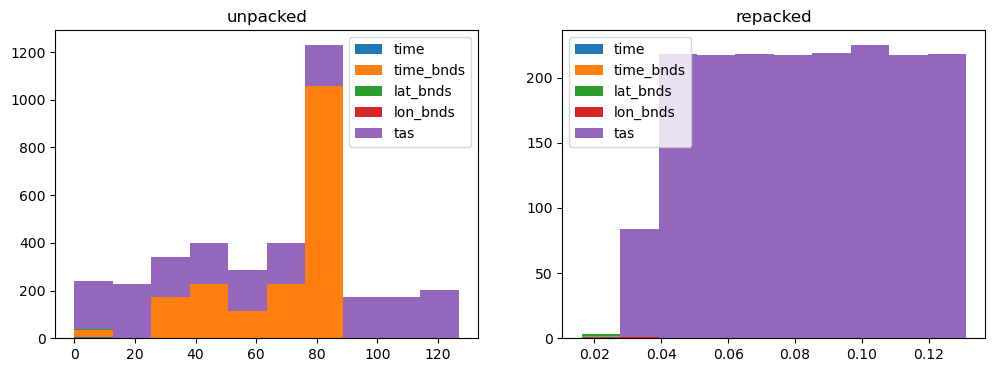

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df_unpacked, stacked=True, label=list(df_unpacked))
axes[1].hist(df_repacked, stacked=True, label=list(df_unpacked))
axes[0].set_title("unpacked")
axes[1].set_title("repacked")
axes[0].legend()
axes[1].legend()

plt.show()

If you are interested in the original files, this are the URLs:

- [tas_tavg-h2m-hxy-u_mon_GLB_gn_PCMDI-test-1-0_historical_r1i1p1f3_185001-199912.nc](https://api.cloud.ifca.es:8080/swift/v1/tests/tas_tavg-h2m-hxy-u_mon_GLB_gn_PCMDI-test-1-0_historical_r1i1p1f3_185001-199912.nc)
- [tas_tavg-h2m-hxy-u_mon_GLB_gn_PCMDI-test-1-0_historical_r1i1p1f3_185001-199912.nc_cmip7repack](https://api.cloud.ifca.es:8080/swift/v1/tests/tas_tavg-h2m-hxy-u_mon_GLB_gn_PCMDI-test-1-0_historical_r1i1p1f3_185001-199912.nc_cmip7repack)

## Repacking tools

[cmip7repack](https://github.com/NCAS-CMS/cmip7_repack) is a tool that allows to repack your netCDF files using a command line interface. It also includes a tool to check if an existing dataset has been repacked. `cmip7repack` relies on [pyfive](https://github.com/NCAS-CMS/pyfive), a pure Python HDF5 file reader. The following commands are included:

- `cmip7repack` - Creates a *repacked* netCDF file from an existing netCDF file.
- `check_cmip7_packing` - Checks if an existing netCDF file has been repacked.

## Remote data access (repacked data)

Once netCDF files have been repacked, they can be safely placed in the cloud (e.g., S3) and accessed efficiently using remote data access.

In [4]:
import numpy as np
import s3fs
import pyfive
import cftime

The data is hosted in an S3-compatible cloud infrastructure at IFCA (Instituto de Física de Cantabria, Spain). The following code sets up `s3fs` to load data from that cloud infrastructure.

In [5]:
S3_URL = "https://api.cloud.ifca.es:8080/swift/v1"

s3params = {
    "endpoint_url": S3_URL,
    "default_fill_cache":False,
    "default_cache_type":"first",
    "default_block_size": 2**20 # 1 MB
}

fs = s3fs.S3FileSystem(anon=True, **s3params)

While accesing an unpacked data is untractable, accessing repacked data in a remote data access fashion is quite affordable.

In [6]:
%%time

filename = "tas_tavg-h2m-hxy-u_mon_GLB_gn_PCMDI-test-1-0_historical_r1i1p1f3_185001-199912.nc_cmip7repack"
uri = "tests/" + filename

with fs.open(uri, "rb") as s3file:
    with pyfive.File(s3file, "r") as f:
        dset_tas  = f["tas"]
        dset_time = f["time"]
        units = f["time"].attrs["units"].decode("ascii")
        calendar = f["time"].attrs["calendar"].decode("ascii")

    tas = dset_tas[:]
    time = dset_time[:]

CPU times: user 14.4 s, sys: 1.54 s, total: 16 s
Wall time: 59.6 s


Generate a plot for the example dataset.

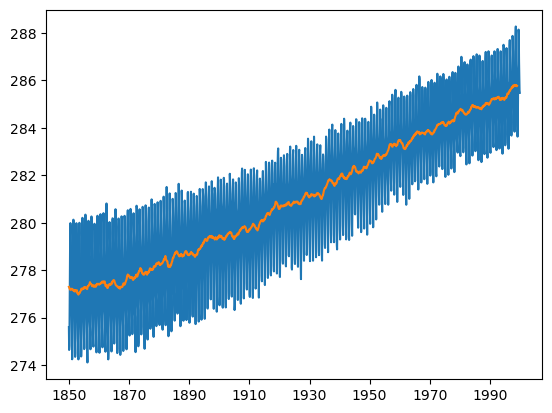

In [7]:
dates = [x for x in cftime.num2date(time, units, calendar)]
years = [x.year for x in dates][::12]

roll = np.convolve(
    tas.mean(axis=(1,2)),
    np.ones(12),
    "valid") / 12

plt.plot(tas.mean(axis=(1,2)))
plt.plot(roll)

ticks = list(range(0, len(dates), 240)) # label each 20 years
plt.xticks(ticks, [dates[i].year for i in ticks])

plt.show()

# References

- `cmip7repack` - https://github.com/NCAS-CMS/cmip7repack
- `pyfive` - https://github.com/NCAS-CMS/pyfive